## **Mini-Project 3:  Computer Vision using GPU and Transfer Learning**

##### *Tran Ngoc bao Huynh and Ong Thao*


#### CSC 180 Intelligent Systems (Fall 2020)

#### Dr. Haiquan Chen, California State University, Sacramento


In [ ]:
# Tran Ngoc Bao Huynh (Student ID: 219763298)
# Ong Thao (Student ID: 219467431)

# Course Title: CSC 180 Intelligent Systems
# Assignment: Mini-Project 3: Computer Vision using GPU and Transfer Learning
# Due Due at 2:00 pm, Friday, October 30, 2020

## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import time

from sklearn import metrics
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, classification_report 


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# plot confusion matrix
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## **Switch and Verify GPU**

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [2]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 



## **Connecting Google Drive to Google Colab**

## **Part I:   Image classification without Transfer Learning** *italicized text*

### **Loading CIFAR-10 Dataset**

In [30]:
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# print out data shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [31]:
# print out a random image in x_train as numpy array
x_train[15]

array([[[100, 168, 231],
        [100, 168, 229],
        [101, 167, 230],
        ...,
        [ 95, 165, 231],
        [ 94, 165, 228],
        [ 95, 167, 229]],

       [[103, 170, 230],
        [103, 168, 228],
        [104, 168, 226],
        ...,
        [ 97, 167, 229],
        [ 97, 166, 227],
        [ 97, 168, 229]],

       [[107, 174, 233],
        [106, 172, 230],
        [106, 173, 229],
        ...,
        [100, 170, 230],
        [100, 170, 230],
        [101, 172, 232]],

       ...,

       [[165, 178, 177],
        [159, 170, 167],
        [167, 177, 170],
        ...,
        [ 75, 117, 154],
        [ 75, 120, 157],
        [ 72, 120, 158]],

       [[158, 174, 172],
        [173, 186, 182],
        [182, 193, 188],
        ...,
        [ 76, 119, 154],
        [ 75, 119, 153],
        [ 77, 121, 154]],

       [[161, 176, 174],
        [162, 176, 172],
        [160, 171, 169],
        ...,
        [ 98, 137, 167],
        [129, 160, 183],
        [162, 185, 202]]

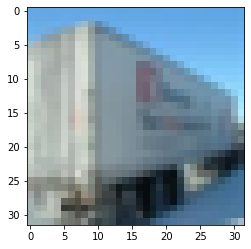

In [32]:
# print it out as image
import matplotlib.pyplot as plt

plt.imshow(x_train[15])

In [33]:
# Convert y_train from 2D to 1D 
# expected output: (50000,)
y_train = y_train.reshape(50000)
y_train.shape

(50000,)

In [34]:
# Convert y_test from 2D to 1D 
# expected output: (10000,)
y_test = y_test.reshape(10000)
y_test.shape

(10000,)

### **Data Preprocessing**

In [35]:
# Convert class vectors to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [36]:
# Unsampling input images to 64 by 64 pixels
x_train = tf.image.resize(x_train, (64, 64))
x_test = tf.image.resize(x_test, (64, 64))
print(x_train.shape)
print(x_test.shape)

(50000, 64, 64, 3)
(10000, 64, 64, 3)


In [37]:
x_train = x_train.numpy()
x_test = x_test.numpy()
print(type(x_train))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [38]:
# Convert data from int to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize data values in the range [0, 1]
x_train /= 255
x_test /= 255
x_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.21568628, 0.22745098, 0.22941177],
         [0.18431373, 0.19607843, 0.19411765],
         ...,
         [0.5921569 , 0.48921567, 0.40098038],
         [0.58431375, 0.4872549 , 0.40294117],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.18921569, 0.20196079, 0.20490196],
         [0.17352942, 0.18529412, 0.1867647 ],
         [0.14215687, 0.15196079, 0.1504902 ],
         ...,
         [0.5615196 , 0.4492647 , 0.3514706 ],
         [0.55710787, 0.4497549 , 0.35637254],
         [0.55490196, 0.45      , 0.35882354]],

        [[0.10490196, 0.11960784, 0.12058824],
         [0.08921569, 0.10098039, 0.10147059],
         [0.05784314, 0.06372549, 0.0632353 ],
         ...,
         [0.5002451 , 0.36936274, 0.25245097],
         [0.5026961 , 0.3747549 , 0.2632353 ],
         [0.50392157, 0.37745097, 0.26862746]],

        ...,

        [[0.7029412 , 0.55      , 0.39607844],
         [0.69558823, 0.53455883, 0.3509804 ]

In [39]:
x_temp = x_test
x_test

array([[[[0.61960787, 0.4392157 , 0.19215687],
         [0.62058824, 0.43823528, 0.19019608],
         [0.622549  , 0.4362745 , 0.18627451],
         ...,
         [0.48431373, 0.3509804 , 0.1382353 ],
         [0.46470588, 0.3392157 , 0.13235295],
         [0.45490196, 0.33333334, 0.12941177]],

        [[0.6137255 , 0.4392157 , 0.19411765],
         [0.6142157 , 0.4379902 , 0.18995099],
         [0.61519605, 0.43553922, 0.18161765],
         ...,
         [0.48431373, 0.35171568, 0.13553922],
         [0.46666667, 0.34142157, 0.13210784],
         [0.45784312, 0.3362745 , 0.13039216]],

        [[0.6019608 , 0.4392157 , 0.19803922],
         [0.6014706 , 0.4375    , 0.18946078],
         [0.6004902 , 0.43406862, 0.17230392],
         ...,
         [0.48431373, 0.35318628, 0.13014705],
         [0.47058824, 0.34583333, 0.13161765],
         [0.46372548, 0.34215686, 0.13235295]],

        ...,

        [[0.23235294, 0.44607842, 0.6509804 ],
         [0.2240196 , 0.43529412, 0.6335784 ]

In [40]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(input_shape)

(50000, 64, 64, 3)
(10000, 64, 64, 3)
(50000, 10)
(10000, 10)
(64, 64, 3)


In [43]:
checkpointer = ModelCheckpoint(filepath="best_weight_2_3x3.hdf5", verbose=2, save_best_only=True)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu', input_shape=input_shape))



model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

start_time = time.time()

model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))

model.load_weights("best_weight_2_3x3.hdf5")

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.28876, saving model to best_weight_2_3x3.hdf5
391/391 - 10s - loss: 1.6159 - accuracy: 0.4456 - val_loss: 1.2888 - val_accuracy: 0.5396
Epoch 2/100

Epoch 00002: val_loss improved from 1.28876 to 1.12323, saving model to best_weight_2_3x3.hdf5
391/391 - 10s - loss: 1.1912 - accuracy: 0.5758 - val_loss: 1.1232 - val_accuracy: 0.5961
Epoch 3/100

Epoch 00003: val_loss improved from 1.12323 to 1.04529, saving model to best_weight_2_3x3.hdf5
391/391 - 10s - loss: 1.0397 - accuracy: 0.6333 - val_loss: 1.0453 - val_accuracy: 0.6322
Epoch 4/100

Epoch 00004: val_loss improved from 1.04529 to 1.00000, saving model to best_weight_2_3x3.hdf5
391/391 - 10s - loss: 0.9068 - accuracy: 0.6796 - val_loss: 1.0000 - val_accuracy: 0.6446
Epoch 5/100

Epoch 00005: val_loss improved from 1.00000 to 0.98895, saving model to best_weight_2_3x3.hdf5
391/391 - 10s - loss: 0.7907 - accuracy: 0.7211 - val_loss: 0.9890 - val_accuracy: 0.6590
Epoch 6/100

E

In [44]:
y_true = np.argmax(y_test, axis=1) 

best_3_3x3 = load_model("best_weight_2_3x3.hdf5")

cnn_no_tl_pred = best_3_3x3.predict(x_temp)
cnn_no_tl_pred = np.argmax(cnn_no_tl_pred, axis=1) 

# Printing precision, recall, and F1 score
cnn_no_tl_acc = metrics.accuracy_score(y_true, cnn_no_tl_pred)
print("CNN with NO Transfer Learning: 2 layer with 3x3 kernel size")
print("-------------------------------------------------------------")
print("Accuracy score: {}".format(cnn_no_tl_acc))
cnn_no_tl_prec = metrics.precision_score(y_true, cnn_no_tl_pred, average= "weighted")
print("Precision score: {}".format(cnn_no_tl_prec))
cnn_no_tl_rec = metrics.recall_score(y_true, cnn_no_tl_pred, average= "weighted")
print("Recall score: {}".format(cnn_no_tl_rec))
cnn_no_tl_score = metrics.f1_score(y_true, cnn_no_tl_pred, average= "weighted")
print("F1 score: {}".format(cnn_no_tl_score))

# Printing classification report
print("\nClassification Report:")
print("-------------------------------------------------------------")
print(metrics.classification_report(y_true, cnn_no_tl_pred))

CNN with NO Transfer Learning: 2 layer with 3x3 kernel size
-------------------------------------------------------------
Accuracy score: 0.6771
Precision score: 0.6835743840281694
Recall score: 0.6771
F1 score: 0.6785610598088391

Classification Report:
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1000
           1       0.80      0.78      0.79      1000
           2       0.56      0.57      0.56      1000
           3       0.45      0.56      0.50      1000
           4       0.58      0.62      0.60      1000
           5       0.64      0.50      0.56      1000
           6       0.79      0.71      0.74      1000
           7       0.76      0.75      0.76      1000
           8       0.77      0.83      0.80      1000
           9       0.74      0.74      0.74      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68

## **CNN Model without Transfer Learning (2 layers, kernel size of 4x4)**


In [ ]:
checkpointer = ModelCheckpoint(filepath="best_weight_2_4x4.hdf5", verbose=2, save_best_only=True)

model_2_4x4 = Sequential([
    Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(64, kernel_size=(4,4), strides=(1,1), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.5),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax') # Output layer
])

# Code for compile, earlystopping and fit.
model_2_4x4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

start_time = time.time()

model_2_4x4.fit(x_train, y_train, epochs=100, batch_size=128, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))

model_2_4x4.load_weights("best_weight_2_4x4.hdf5")

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.26950, saving model to best_weight_2_4x4.hdf5
391/391 - 11s - loss: 1.5838 - accuracy: 0.4174 - val_loss: 1.2695 - val_accuracy: 0.5400
Epoch 2/100

Epoch 00002: val_loss improved from 1.26950 to 1.15049, saving model to best_weight_2_4x4.hdf5
391/391 - 11s - loss: 1.2288 - accuracy: 0.5595 - val_loss: 1.1505 - val_accuracy: 0.6032
Epoch 3/100

Epoch 00003: val_loss improved from 1.15049 to 0.91275, saving model to best_weight_2_4x4.hdf5
391/391 - 11s - loss: 1.0503 - accuracy: 0.6276 - val_loss: 0.9127 - val_accuracy: 0.6824
Epoch 4/100

Epoch 00004: val_loss improved from 0.91275 to 0.85748, saving model to best_weight_2_4x4.hdf5
391/391 - 11s - loss: 0.9465 - accuracy: 0.6688 - val_loss: 0.8575 - val_accuracy: 0.7048
Epoch 5/100

Epoch 00005: val_loss improved from 0.85748 to 0.80769, saving model to best_weight_2_4x4.hdf5
391/391 - 11s - loss: 0.8681 - accuracy: 0.6968 - val_loss: 0.8077 - val_accuracy: 0.7180
Epoch 6/100

E

In [ ]:
model_2_4x4.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 64, 64, 32)        1568      
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 29, 29, 64)        32832     
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 11, 11, 128)       131200    
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 5, 5, 128)       

## **CNN Model without Transfer Learning (3 layers, kernel size of 3x3)**

In [18]:
checkpointer = ModelCheckpoint(filepath="best_weight_3_3x3.hdf5", verbose=2, save_best_only=True)

model_3_3x3 = Sequential([
    Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.5),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax') # Output layer
])

# Code for compile, earlystopping and fit.
model_3_3x3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

start_time = time.time()

model_3_3x3.fit(x_train, y_train, epochs=100, verbose=2, batch_size=128, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))

model_3_3x3.load_weights("best_weight_3_3x3.hdf5")

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.24066, saving model to best_weight_3_3x3.hdf5
391/391 - 4s - loss: 1.5442 - accuracy: 0.4387 - val_loss: 1.2407 - val_accuracy: 0.5601
Epoch 2/100

Epoch 00002: val_loss improved from 1.24066 to 1.05911, saving model to best_weight_3_3x3.hdf5
391/391 - 4s - loss: 1.1865 - accuracy: 0.5770 - val_loss: 1.0591 - val_accuracy: 0.6333
Epoch 3/100

Epoch 00003: val_loss improved from 1.05911 to 0.90461, saving model to best_weight_3_3x3.hdf5
391/391 - 4s - loss: 1.0393 - accuracy: 0.6310 - val_loss: 0.9046 - val_accuracy: 0.6853
Epoch 4/100

Epoch 00004: val_loss improved from 0.90461 to 0.84777, saving model to best_weight_3_3x3.hdf5
391/391 - 4s - loss: 0.9305 - accuracy: 0.6744 - val_loss: 0.8478 - val_accuracy: 0.7063
Epoch 5/100

Epoch 00005: val_loss improved from 0.84777 to 0.79167, saving model to best_weight_3_3x3.hdf5
391/391 - 4s - loss: 0.8449 - accuracy: 0.7019 - val_loss: 0.7917 - val_accuracy: 0.7252
Epoch 6/100

Epoch 

In [ ]:
# Print model summary

model_3_3x3.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 6, 6, 128)       

### **CNN Models with NO Transfer Learning:** 
*Precision, Recall, F1 score, and Classification Report for 2 Layer and Kernel-size of 4x4*

In [ ]:
y_true = np.argmax(y_test, axis=1) 

best_2_4x4 = load_model("best_weight_2_4x4.hdf5")

cnn_no_tl_pred = best_2_4x4.predict(x_test)
cnn_no_tl_pred = np.argmax(cnn_no_tl_pred, axis=1) 

# Printing precision, recall, and F1 score
cnn_no_tl_acc = metrics.accuracy_score(y_true, cnn_no_tl_pred)
print("CNN with NO Transfer Learning: 2 layer with 4x4 kernel size")
print("-------------------------------------------------------------")
print("Accuracy score: {}".format(cnn_no_tl_acc))
cnn_no_tl_prec = metrics.precision_score(y_true, cnn_no_tl_pred, average= "weighted")
print("Precision score: {}".format(cnn_no_tl_prec))
cnn_no_tl_rec = metrics.recall_score(y_true, cnn_no_tl_pred, average= "weighted")
print("Recall score: {}".format(cnn_no_tl_rec))
cnn_no_tl_score = metrics.f1_score(y_true, cnn_no_tl_pred, average= "weighted")
print("F1 score: {}".format(cnn_no_tl_score))

# Printing classification report
print("\nClassification Report:")
print("-------------------------------------------------------------")
print(metrics.classification_report(y_true, cnn_no_tl_pred))

CNN with NO Transfer Learning: 2 layer with 4x4 kernel size
-------------------------------------------------------------
Accuracy score: 0.7832
Precision score: 0.7830656582239498
Recall score: 0.7832
F1 score: 0.7828437553136911

Classification Report:
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.89      0.89      0.89      1000
           2       0.72      0.69      0.70      1000
           3       0.62      0.59      0.61      1000
           4       0.76      0.75      0.76      1000
           5       0.66      0.70      0.68      1000
           6       0.81      0.85      0.83      1000
           7       0.80      0.83      0.81      1000
           8       0.86      0.88      0.87      1000
           9       0.90      0.84      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78

*Precision, Recall, F1 score, and Classification Report for 3 Layer and Kernel-size of 3x3*

In [13]:
y_true = np.argmax(y_test, axis=1) 

best_3_3x3 = load_model("best_weight_3_3x3.hdf5")

cnn_no_tl_pred_best = best_3_3x3.predict(x_temp)
cnn_no_tl_pred_best = np.argmax(cnn_no_tl_pred_best, axis=1) 

# Printing precision, recall, and F1 score
cnn_no_tl_acc = metrics.accuracy_score(y_true, cnn_no_tl_pred_best)
print("CNN with NO Transfer Learning: 3 layer with 3x3 kernel size")
print("-------------------------------------------------------------")
print("Accuracy score: {}".format(cnn_no_tl_acc))
cnn_no_tl_prec = metrics.precision_score(y_true, cnn_no_tl_pred_best, average= "weighted")
print("Precision score: {}".format(cnn_no_tl_prec))
cnn_no_tl_rec = metrics.recall_score(y_true, cnn_no_tl_pred_best, average= "weighted")
print("Recall score: {}".format(cnn_no_tl_rec))
cnn_no_tl_score = metrics.f1_score(y_true, cnn_no_tl_pred_best, average= "weighted")
print("F1 score: {}".format(cnn_no_tl_score))

# Printing classification report
print("\nClassification Report:")
print("-------------------------------------------------------------")
print(metrics.classification_report(y_true, cnn_no_tl_pred_best))

CNN with NO Transfer Learning: 3 layer with 3x3 kernel size
-------------------------------------------------------------
Accuracy score: 0.7871
Precision score: 0.7875760717776142
Recall score: 0.7871
F1 score: 0.7864359278608825

Classification Report:
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1000
           1       0.89      0.87      0.88      1000
           2       0.69      0.73      0.71      1000
           3       0.66      0.56      0.60      1000
           4       0.77      0.73      0.75      1000
           5       0.66      0.73      0.70      1000
           6       0.84      0.83      0.83      1000
           7       0.82      0.85      0.83      1000
           8       0.90      0.85      0.87      1000
           9       0.86      0.87      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79

## **Testing Five Images with 2 layer, 4x4 Kernel Size Model**

Predicted: Ship
Actual: Ship


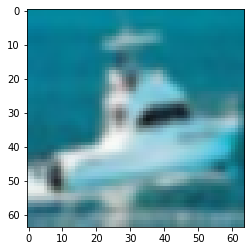

In [ ]:
import matplotlib.pyplot as mpl
img_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

y_true = np.argmax(y_test, axis=1)
pred = best_2_4x4.predict(x_test)
pred = np.argmax(pred, axis=1)

print("Predicted: {}".format(img_labels[pred[1200]]))
print("Actual: {}".format(img_labels[y_true[1200]]))
mpl.imshow(x_test[1200])

Predicted: Truck
Actual: Truck


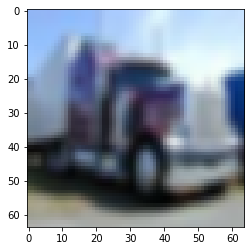

In [ ]:
print("Predicted: {}".format(img_labels[pred[2020]]))
print("Actual: {}".format(img_labels[y_true[2020]]))
mpl.imshow(x_test[2020])

Predicted: Dog
Actual: Dog


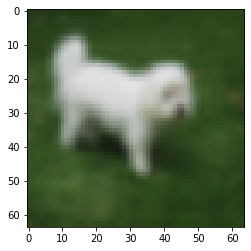

In [ ]:
print("Predicted: {}".format(img_labels[pred[3200]]))
print("Actual: {}".format(img_labels[y_true[3200]]))
mpl.imshow(x_test[3200])

Predicted: Horse
Actual: Ship


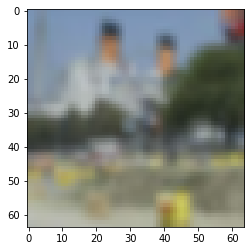

In [ ]:
print("Predicted: {}".format(img_labels[pred[4000]]))
print("Actual: {}".format(img_labels[y_true[4000]]))
mpl.imshow(x_test[4000])

Predicted: Cat
Actual: Cat


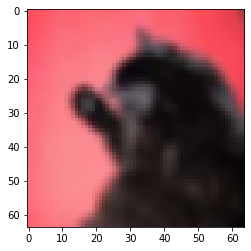

In [ ]:

print("Predicted: {}".format(img_labels[pred[5200]]))
print("Actual: {}".format(img_labels[y_true[5200]]))
mpl.imshow(x_test[5200])

## **Testing Five Images with 3 layer, 3x3 Kernel Size Model**

Predicted: Ship
Actual: Ship


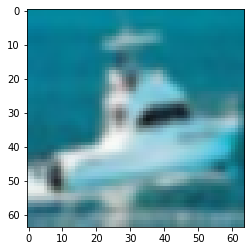

In [ ]:
import matplotlib.pyplot as mpl
img_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

y_true = np.argmax(y_test, axis=1)
pred = best_3_3x3.predict(x_test)
pred = np.argmax(pred, axis=1)

print("Predicted: {}".format(img_labels[pred[1200]]))
print("Actual: {}".format(img_labels[y_true[1200]]))
mpl.imshow(x_test[1200])

Predicted: Truck
Actual: Truck


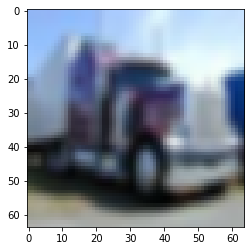

In [ ]:
print("Predicted: {}".format(img_labels[pred[2020]]))
print("Actual: {}".format(img_labels[y_true[2020]]))
mpl.imshow(x_test[2020])

Predicted: Dog
Actual: Dog


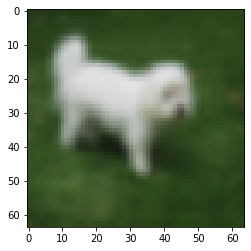

In [ ]:
print("Predicted: {}".format(img_labels[pred[3200]]))
print("Actual: {}".format(img_labels[y_true[3200]]))
mpl.imshow(x_test[3200])

Predicted: Airplane
Actual: Ship


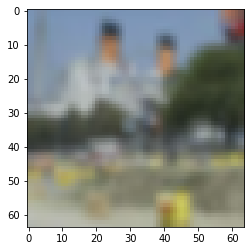

In [ ]:
print("Predicted: {}".format(img_labels[pred[4000]]))
print("Actual: {}".format(img_labels[y_true[4000]]))
mpl.imshow(x_test[4000])

Predicted: Cat
Actual: Cat


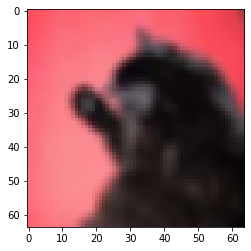

In [ ]:
print("Predicted: {}".format(img_labels[pred[5200]]))
print("Actual: {}".format(img_labels[y_true[5200]]))
mpl.imshow(x_test[5200])



## Part II:   CNN model with Transfer Learning

In [14]:
# We load data again.   The data split between train and test sets:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


### VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 



### Find a way to do upsampling for each image to increase its resolution from 32x32 to 64x64. One option is to use the function resize(), which is provided by scikit-image library (https://scikit-image.org/)


### Things to note: 

#### (1) If you use resize() in scikit-image, that function also normalizes the input image so you may not want to normalize twice.

#### (2) Apply upsampling to x_train and x_test seperately. 

In [15]:
import skimage.transform

new_x_train = []

for image_32 in x_train:
  image_64 = skimage.transform.resize(image_32, (64, 64))
  new_x_train.append(image_64)

# Change from ndarray to np array
new_x_train = np.asarray(new_x_train)

# this process may take about a few minutes ....

In [16]:
new_x_test = []

for image_32 in x_test:
  image_64 = skimage.transform.resize(image_32, (64, 64))
  new_x_test.append(image_64)

# Change from ndarray to np array
new_x_test = np.asarray(new_x_test)

# this process may take about a few minutes ....

### Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [17]:
# Convert from 2D to 1D 
y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

# one hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [45]:
# Test shape
input_shape = (new_x_train.shape[1], new_x_train.shape[2], new_x_train.shape[3])
print(new_x_train.shape)
print(new_x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(input_shape)


(50000, 64, 64, 3)
(10000, 64, 64, 3)
(50000, 10)
(10000, 10)
(64, 64, 3)


###  Load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [46]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

checkpointer = ModelCheckpoint(filepath="vgg_model.hdf5", verbose=2, save_best_only=True)

model = Sequential()

# write your code here

for layer in vgg_model.layers:
  model.add(layer)

# print out the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

### Write your code in the cell below to freeze the weights in each layer in the new model

In [48]:
for layer in model.layers:
  layer.trainable = False

###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [49]:
# Add some "Dense" layers here, including output layer
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(y_train.shape[1], activation='softmax'))


###  Write your code below for compile and fit. 

### Train your new model. 

### Notice that you should use earlystopping.

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Use categorical crossentropy loss since it is a classification problem
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6),metrics=['accuracy'])

# Stop training when model stops improving
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

start_time = time.time()

model.fit(new_x_train, y_train, validation_data=(new_x_test, y_test), 
           callbacks=[monitor, checkpointer], verbose=2, epochs=100, batch_size=128)

model.load_weights("vgg_model.hdf5")

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.99107, saving model to vgg_model.hdf5
391/391 - 8s - loss: 1.2110 - accuracy: 0.5845 - val_loss: 0.9911 - val_accuracy: 0.6570
Epoch 2/100

Epoch 00002: val_loss improved from 0.99107 to 0.97269, saving model to vgg_model.hdf5
391/391 - 8s - loss: 0.9246 - accuracy: 0.6807 - val_loss: 0.9727 - val_accuracy: 0.6696
Epoch 3/100

Epoch 00003: val_loss improved from 0.97269 to 0.91272, saving model to vgg_model.hdf5
391/391 - 8s - loss: 0.8257 - accuracy: 0.7149 - val_loss: 0.9127 - val_accuracy: 0.6842
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.91272
391/391 - 8s - loss: 0.7575 - accuracy: 0.7358 - val_loss: 0.9133 - val_accuracy: 0.6889
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.91272
391/391 - 8s - loss: 0.6854 - accuracy: 0.7612 - val_loss: 0.9153 - val_accuracy: 0.6900
Elapsed time: 0:00:41.12


### Write your code below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

In [51]:
from sklearn import metrics

y_true = np.argmax(y_test, axis=1) 

vgg_mod = load_model("vgg_model.hdf5")

cnn_tl_pred = vgg_mod.predict(new_x_test)
cnn_tl_pred = np.argmax(cnn_tl_pred, axis=1) 

# Printing precision, recall, and F1 score
cnn_tl_acc = metrics.accuracy_score(y_true, cnn_tl_pred)
print("CNN with Transfer Learning: ")
print("-------------------------------------------------------------")
print("Accuracy score: {}".format(cnn_tl_acc))
cnn_tl_prec = metrics.precision_score(y_true, cnn_tl_pred, average= "weighted")
print("Precision score: {}".format(cnn_tl_prec))
cnn_tl_rec = metrics.recall_score(y_true, cnn_tl_pred, average= "weighted")
print("Recall score: {}".format(cnn_tl_rec))
cnn_tl_score = metrics.f1_score(y_true, cnn_tl_pred, average= "weighted")
print("F1 score: {}".format(cnn_tl_score))

# Printing classification report
print("\nClassification Report:")
print("-------------------------------------------------------------")
print(metrics.classification_report(y_true, cnn_tl_pred))

# Compare with best model of NO Transfer Learning
cnn_no_tl_acc = metrics.accuracy_score(y_true, cnn_no_tl_pred_best)
print("\nCNN with Best None Transfer Learning: ")
print("-------------------------------------------------------------")
print("Accuracy score: {}".format(cnn_no_tl_acc))
cnn_no_tl_rec_best = metrics.precision_score(y_true, cnn_no_tl_pred_best, average= "weighted")
print("Precision score: {}".format(cnn_no_tl_rec_best))
cnn_no_tl_rec_best = metrics.recall_score(y_true, cnn_no_tl_pred_best, average= "weighted")
print("Recall score: {}".format(cnn_no_tl_rec_best))
cnn_no_tl_score_best = metrics.f1_score(y_true, cnn_no_tl_pred_best, average= "weighted")
print("F1 score: {}".format(cnn_no_tl_score_best))


CNN with Transfer Learning: 
-------------------------------------------------------------
Accuracy score: 0.6842
Precision score: 0.6978617540342762
Recall score: 0.6842
F1 score: 0.6837022154771636

Classification Report:
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1000
           1       0.74      0.82      0.78      1000
           2       0.75      0.53      0.62      1000
           3       0.53      0.41      0.46      1000
           4       0.67      0.60      0.63      1000
           5       0.46      0.76      0.58      1000
           6       0.74      0.68      0.71      1000
           7       0.71      0.76      0.74      1000
           8       0.85      0.76      0.80      1000
           9       0.78      0.73      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.70      0.68      0.68     10000
weighted a

[[730  21  58  26  44   4  14  13  60  30]
 [  9 828   7  15   7  13  13  10  28  70]
 [ 36  11 633  68  93  46  85  21   5   2]
 [ 12  24  50 595  51 129  80  31   7  21]
 [ 11   9  51  85 697  31  54  46   6  10]
 [  4   9  44 190  50 609  37  41   3  13]
 [  4  16  35  77  62  40 755   2   7   2]
 [  6   9  27  56  87  59  13 724   3  16]
 [ 50  36  18  34  16   5   7   8 796  30]
 [ 22  83   7  37  15   6   8  13  24 785]]
Plotting confusion matrix


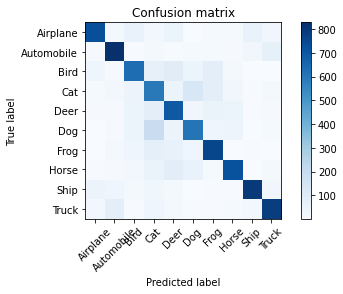

In [38]:
import matplotlib.pyplot as mpl
img_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

matrix = confusion_matrix(y_true, cnn_tl_pred)
print(matrix)

print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(matrix,img_labels)
plt.show()

### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model with transfer learning. 

### Include your findings in the project report.

Predicted No Transfer: Ship
Predicted Transfer   : Ship
Actual: Ship


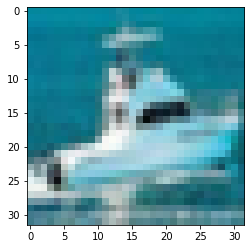

In [39]:
y_true = np.argmax(y_test, axis=1)

pred_no = best_3_3x3.predict(x_temp)
pred_no = np.argmax(pred_no, axis=1)

print("Predicted No Transfer: {}".format(img_labels[pred_no[1200]]))
print("Predicted Transfer   : {}".format(img_labels[cnn_tl_pred[1200]]))
print("Actual: {}".format(img_labels[y_true[1200]]))
mpl.imshow(x_test[1200])

Predicted No Transfer: Truck
Predicted Transfer   : Truck
Actual: Truck


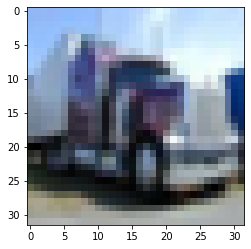

In [40]:
y_true = np.argmax(y_test, axis=1)

pred_no = best_3_3x3.predict(x_temp)
pred_no = np.argmax(pred_no, axis=1)

print("Predicted No Transfer: {}".format(img_labels[pred_no[2020]]))
print("Predicted Transfer   : {}".format(img_labels[cnn_tl_pred[2020]]))
print("Actual: {}".format(img_labels[y_true[2020]]))
mpl.imshow(x_test[2020])

Predicted No Transfer: Dog
Predicted Transfer   : Dog
Actual: Dog


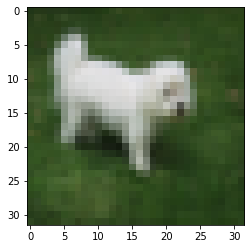

In [41]:
y_true = np.argmax(y_test, axis=1)

pred_no = best_3_3x3.predict(x_temp)
pred_no = np.argmax(pred_no, axis=1)

print("Predicted No Transfer: {}".format(img_labels[pred_no[3200]]))
print("Predicted Transfer   : {}".format(img_labels[cnn_tl_pred[3200]]))
print("Actual: {}".format(img_labels[y_true[3200]]))
mpl.imshow(x_test[3200])

Predicted No Transfer: Airplane
Predicted Transfer   : Horse
Actual: Ship


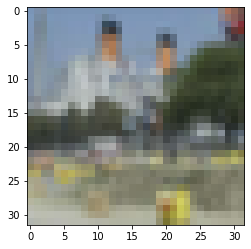

In [42]:
y_true = np.argmax(y_test, axis=1)

pred_no = best_3_3x3.predict(x_temp)
pred_no = np.argmax(pred_no, axis=1)

print("Predicted No Transfer: {}".format(img_labels[pred_no[4000]]))
print("Predicted Transfer   : {}".format(img_labels[cnn_tl_pred[4000]]))
print("Actual: {}".format(img_labels[y_true[4000]]))
mpl.imshow(x_test[4000])

Predicted No Transfer: Dog
Predicted Transfer   : Frog
Actual: Cat


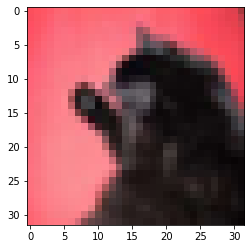

In [43]:
y_true = np.argmax(y_test, axis=1)

pred_no = best_3_3x3.predict(x_temp)
pred_no = np.argmax(pred_no, axis=1)

print("Predicted No Transfer: {}".format(img_labels[pred_no[5200]]))
print("Predicted Transfer   : {}".format(img_labels[cnn_tl_pred[5200]]))
print("Actual: {}".format(img_labels[y_true[5200]]))
mpl.imshow(x_test[5200])